## Skin Lesions Classification using Computer Vision and Convolutional Neural Networks

Today, skin cancer is a public health and economic issue, in fact several researches state that skin diseases are one of the most common human illnesses, affecting every age, gender and pervading many cultures, summing up to between 30% and 70% of people in the United States. The recommended way to detect early skin diseases is to be aware of new or changing skin growths. One of the most adopted techniques for skin lesion analysis is the so-called ABCD analysis, that consists of scanning the skin area of interest for asymmetry (A), border irregularity (B), colors variegation (C), diameter (D).  
The emergence of powerful machine learning techniques such as deep learning has enabled the development of intelligent medical image analysis
systems that, through the use of Artificial and Convolutional Neural Networks, have been proved to have remarkable performance in comparison to
standard methods.  
Given this background, this project will guide its efforts in applying deep learning and some image processing techniques to images of the HAM10000 dataset in order to develop an advanced skin lesion classification system:
after applying some preprocessing techniques to enhance contrast and remove hairs, images are processed using two distinct pipelines. The first one uses the AlexNet convolutional neural network (CNN) for image classification, while in the second one we firstly find the region representing the lesion using the marker-based watershed segmentation algorithm, and then we perform feature extraction based on the ABCDT analysis, an extension of the classical ABCD analysis, so that the extracted features can be used for image classification using the SVM machine learning model.


---



Import all necessary Python modules and define basic info about paths, images and training parameters

In [0]:
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
import os
import shutil
import warnings
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.metrics import confusion_matrix, f1_score, precision_score, \
                            recall_score, accuracy_score, classification_report

import seaborn as sns; sns.set()

from skimage import io, exposure, morphology, filters, color, \
                    segmentation, feature, measure, img_as_float, img_as_ubyte
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
warnings.simplefilter("ignore")
from scipy import ndimage as ndi

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, \
                         Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import Callback

dataset_default_path = './dataset'
train_set_path = './train'
test_set_path = './test'
weights_filename = "./alexnet_weights.h5"

rand_seed = 0

# Number of epochs, where each epoch represents one forward pass and one backward pass
# of all the training samples
num_epochs = 75
# the batch size defines the number of samples that will be propagated through the network.
# In other words it represents the number of training examples in one forward/backward pass.
# We will use the mini-batch approach instead of using the whole training set for each pass.
batch_size = 50
# shape of the dataset images: length = 450 px, height = 450 px, channels = 3 (RGB)
img_shape = (600, 450, 3)

# Minimum number of images of HAM10000 dataset to use 
min_samples = 200
# Maximum number of images (and their info) that will be printed during
# preprocessing, segmentation and feature extraction.
# This is needed to avoid the error message: 
# "Buffered data was truncated after reaching the output size limit"
# because there is a limited memory for displaying output of a cell on Colab
plot_limit = 200

Using TensorFlow backend.


**Create** 3 new directories for storing images:

*   **dataset:** it will contain all the images of the HAM10000 datset
*   **train:** it will contain the preprocessed images of the HAM10000 datset to be used for training the neural networks
*   **test:** it will contain the preprocessed images of the HAM10000 datset to be used for doing performance evaluation

In [0]:
!mkdir -p dataset train test

Mount Google Drive to import the dataset tarballs

In [0]:
from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
drive.mount('/content/drive')

Create the *ham10000* directory in the mounted Drive and select it as the current directory

In [0]:
!mkdir -p "/content/drive/My Drive/ham10000"
%cd "/content/drive/My Drive/ham10000"

/content/drive/My Drive/ham10000


Download from Harvard Dataverse the first part/tarball (HAM10000_images_part_1.zip) of HAM10000 dataset and unzip it into the */content/dataset* folder.

See also [HAM10000 dataset documentation](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T)

In [0]:
%%bash

DATASET_DIR="/content/dataset/"

if [ ! -f "HAM10000_images_part_1.zip" ]; then
    echo "Downloading HAM10000_images_part_1.zip ..."
    wget --show-progress --progress=bar:force https://dataverse.harvard.edu/api/access/datafile/3172585 -O HAM10000_images_part_1.zip
fi

echo "Unpacking HAM10000_images_part_1.zip ..."
unzip -q HAM10000_images_part_1.zip -d $DATASET_DIR

Unpacking HAM10000_images_part_1.zip ...


Download from Harvard Dataverse the second part/tarball (HAM10000_images_part_2.zip) of HAM10000 dataset and unzip it into the */content/dataset* folder.

In [0]:
%%bash

DATASET_DIR="/content/dataset/"

if [ ! -f "HAM10000_images_part_2.zip" ]; then
    echo "Downloading HAM10000_images_part_2.zip ..."
    wget --show-progress --progress=bar:force https://dataverse.harvard.edu/api/access/datafile/3172584 -O HAM10000_images_part_2.zip
fi

echo "Unpacking HAM10000_images_part_2.zip ..."
unzip -q HAM10000_images_part_2.zip -d $DATASET_DIR

Unpacking HAM10000_images_part_2.zip ...


Download from Harvard Dataverse the metadata (HAM10000_metadata.csv) of HAM10000 dataset.

In [0]:
%%bash

if [ ! -f "HAM10000_metadata.csv" ]; then
    echo "Downloading HAM10000_metadata.csv"
    wget --show-progress --progress=bar:force https://dataverse.harvard.edu/api/access/datafile/3172582?format=original -O HAM10000_metadata.csv
fi

Check if the images have been successfully extracted

In [0]:
%%bash

DATASET_DIR="/content/dataset/"

if [ -d $DATASET_DIR ] && [ $(ls -1 $DATASET_DIR | wc -l) -eq 10015 ]; then
    echo "Successfully built the dataset"
else
    echo "Error when building the dataset"
fi

Successfully built the dataset


Move into the root folder of Colab (*/content/*)

In [0]:
%cd /content

/content


**`image_show()`** allows to plot a single image and set some useful parameters like `size` and `cmap`, using `matplotlib`.

In [0]:
def image_show(image, size=None, cmap=None, no_axis=True):
    """
    Plot a single image.
    
    Parameters
    ----------
    image : ndarray
        Image to be plotted.
    size : tuple of in (length, height)
        Sizes of the figure.
    cmap : str
        Figure colormap.
    no_axis : bool
        Whether or not to show axis
    """
    if size is None:
        size = plt.rcParams['figure.figsize']
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=size)
    ax.grid(False)
    if cmap is not None:
        ax.imshow(image, cmap=cmap)
    else:
        ax.imshow(image)
    if no_axis:
        ax.axis('off')
    return fig, ax

**`imshow_all()`** allows to plot a series of images side-by-side using `matplotlib`.

In [0]:
def imshow_all(*images, **kwargs):
    """
    Plot a series of images side-by-side.

    Convert all images to float so that images have a common intensity range.

    Parameters
    ----------
    limits : str
        Control the intensity limits. By default, 'image' is used set the
        min/max intensities to the min/max of all images. Setting `limits` to
        'dtype' can also be used if you want to preserve the image exposure.
    titles : list of str
        Titles for subplots. If the length of titles is less than the number
        of images, empty strings are appended.
    kwargs : dict
        Additional keyword-arguments passed to `imshow`.
    """
    images = [img_as_float(img) for img in images]

    titles = kwargs.pop('titles', [])
    if len(titles) != len(images):
        titles = list(titles) + [''] * (len(images) - len(titles))

    limits = kwargs.pop('limits', 'image')
    if limits == 'image':
        kwargs.setdefault('vmin', min(img.min() for img in images))
        kwargs.setdefault('vmax', max(img.max() for img in images))
    elif limits == 'dtype':
        vmin, vmax = dtype_limits(images[0])
        kwargs.setdefault('vmin', vmin)
        kwargs.setdefault('vmax', vmax)

    nrows, ncols = kwargs.get('shape', (1, len(images)))
    
    axes_off = kwargs.pop('axes_off', False)

    size = nrows * kwargs.pop('size', 5)
    width = size * len(images)
    if nrows > 1:
        width /= nrows * 1.33
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width, size))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, **kwargs)
        ax.set_title(label)
        ax.grid(False)
        if axes_off:
            ax.set_axis_off()

**`imshow_with_histogram()`** allows to plot an image along with its histogram using `matplotlib`.

In [0]:
def imshow_with_histogram(image, **kwargs):
    """
    Plot an image side-by-side with its histogram.

    - Plot the image next to the histogram
    - Plot each RGB channel separately (if input is color)
    - Automatically flatten channels
    - Select reasonable bins based on the image's dtype
    """
    # create a new subplot made of 2 figures
    width, height = plt.rcParams['figure.figsize']
    fig, (ax_image, ax_hist) = plt.subplots(ncols=2, figsize=(2*width, height))
    
    titles = kwargs.pop('titles', [])
    if len(titles) == 2:
        ax_image.set_title(titles[0])
        ax_hist.set_title(titles[1])

    # first plot the image
    kwargs.setdefault('cmap', plt.cm.gray)
    ax_image.imshow(image, **kwargs)
    
    # then plot its histogram
    if image.ndim == 2:
        hist, bin_centers = exposure.histogram(image)
        ax_hist.fill_between(bin_centers, hist, alpha=0.3, color='black', **kwargs)
    elif image.ndim == 3:
        # `channel` is the red, green, or blue channel of the image.
        for channel, channel_color in zip([channel for channel in np.rollaxis(image, -1)], 'rgb'):
            hist, bin_centers = exposure.histogram(channel)
            ax_hist.fill_between(bin_centers, hist, alpha=0.3, color=channel_color, **kwargs)
    ax_hist.set_xlabel('intensity')
    ax_hist.set_ylabel('# pixels')
    # ax_hist.grid(False)

    ax_image.set_axis_off()
    # match axes height
    plt.draw()
    dst = ax_hist.get_position()
    src = ax_image.get_position()
    ax_hist.set_position([dst.xmin, src.ymin, dst.width, src.height])
    return ax_image, ax_hist

Define useful functions to adapt gray-scale filters and image processing techniques to RGB images:
there are many filters of *scikit-image* library that are designed to work with gray-scale images but not with color images. In order to adapt them to RGB images, *scikit-image* provides the **`adapt_rgb`** decorator.

To actually use the adapt_rgb decorator, you have to decide how you want to adapt the RGB image for use with the gray-scale filter. There are two pre-defined handlers:

*   **`each_channel`**: it passes each of the RGB channels to the filter one-by-one, and stitch the results back into an RGB image.
*   **`hsv_value`**: it firstly converts the RGB image to HSV and pass the value (V) channel to the filter. Then the filtered result is inserted back into the HSV image and finally it is converted back to RGB.

In our case we use the *adapt_rgb* decorator to adapt the **morphological closing operator (`skimage.morphology.closing`)** and the **median filter (`skimage.filters.median`)**.

The chosen structuring element (kernel) is a disk of radius 7.

In [0]:
structuring_element = morphology.disk(7)

@adapt_rgb(each_channel)
def morph_closing_each(image, struct_element):
    return morphology.closing(image, struct_element)


@adapt_rgb(hsv_value)
def morph_closing_hsv(image, struct_element):
    return morphology.closing(image, struct_element)

In [0]:
@adapt_rgb(each_channel)
def median_filter_each(image, struct_element):
    return filters.median(image, struct_element)


@adapt_rgb(hsv_value)
def median_filter_hsv(image, struct_element):
    return filters.median(image, struct_element)

**`build_train_test()`** chooses (randomly) `num_samples` images from the HAM10000 dataset (if `num_samples` is zero (by default) or less than zero, all the samples in the dataset will be chosen) and split them into the training and test sets in a stratified fashion. Through the `train_set_frac` parameter, the user can choose the proportion of the dataset to include in the train split.

In [0]:
def build_train_test(num_samples=0, train_set_frac=0.75, dataset_path=dataset_default_path,
                     train_path=train_set_path, test_path=test_set_path,
                     overwrite=False):
    """
    Build the training and test set.

    Parameters
    ----------
    num_samples : int
        Number of samples to select from the dataset. If zero or less than zero,
        all the samples in the dataset will be chosen.
        If higher than the dataset size it will be set to the dataset size.
    train_set_frac : float
        It represents the proportion of the dataset to include in the train split.
        If less than 0.0 or greater than 1.0 it will be set to the default value (0.75).
    dataset_path : str
        It should point to a valid path containing the images of the HAM10000 dataset.
        If not valid it will be set to the default path './dataset'.
    train_path : str
        It should point to a valid path to store images of the training set.
        If not valid it will be set to the default path './train'.
    test_path : str
        It should point to a valid path to store images of the test set.
        If not valid it will be set to the default path './test'.
    overwrite : bool
        Specifies whether or not to overwrite the directories related to training
        and test set.
    
    Returns training set (DataFrame), test set (DataFrame) and class labels
    """
    # if 'dataset_path' is not valid set to the default path ('./dataset')
    if not os.path.isdir(dataset_path):
        print('Warning: {} not found. We will use {} for the dataset'.format(
              dataset_path, dataset_default_path))
        dataset_path = dataset_default_path
    # Get the absolute path of the dataset directory
    abs_dataset_path = os.path.abspath(dataset_path)

    # if 'train_path' is not valid set to the default path ('./train')
    if not os.path.isdir(train_path):
        print('Warning: {} not found. We will use {} to store the training set'.format(
              train_path, train_set_path))
        train_path = train_set_path
    # Get the absolute path of the training set
    abs_train_path = os.path.abspath(train_path)
    if overwrite:
        shutil.rmtree(abs_train_path)
        os.mkdir(abs_train_path)

    # If 'test_path' is not valid set to the default path ('./test')
    if not os.path.isdir(test_path):
        print('Warning: {} not found. We will use {} to store the test set'.format(
              test_path, test_set_path))
        test_path = test_set_path
    # Get the absolute path of the test set
    abs_test_path = os.path.abspath(test_path)
    if overwrite:
        shutil.rmtree(abs_test_path)
        os.mkdir(abs_test_path)

    # Read the dataset metadata from HAM10000_metadata.csv as a Pandas dataframe
    # ham10000_df = pd.read_csv('HAM10000_metadata.csv')
    ham10000_df = pd.read_csv('/content/drive/My Drive/ham10000/HAM10000_metadata.csv')
    
    # For each image name in the 'image_id' column add the '.jpg' suffix.
    # This is needed by flow_from_dataframe since each item in 'image_id' column
    # must specify the (relative) path of the corresponding image
    # (see 'flow_from_dataframe' documentation)
    for img_idx in range(ham10000_df['image_id'].count()):
        ham10000_df.at[img_idx, 'image_id'] += '.jpg'

    # Get class labels
    classes = list(set(ham10000_df.dx))
    print('Class labels: {}'.format(classes))

    # Get and print the number of images in the dataset
    num_images = ham10000_df.image_id.count()
    print('Number of images in the HAM10000 dataset: {}'.format(num_images))

    if 0 < num_samples < min_samples:
        print('Warning: The chosen number of samples is low. '
              'It will be set by default to {}'.format(min_samples))
        ham10000_df = ham10000_df.sample(n=min_samples, random_state=rand_seed)
        print('Number of images in the reduced dataset: {}'.format(min_samples))
    elif num_samples > num_images:
        print('Warning: The chosen number of samples is greater than the dataset size. '
              'The dataset size will not be changed')
    elif min_samples <= num_samples <= num_images:
        ham10000_df = ham10000_df.sample(n=num_samples, random_state=rand_seed)
        print('Number of images in the reduced dataset: {}'.format(num_samples))

    # Print the number of images in each class (dataset)
    print('Number of images for each class (dataset):')
    print(ham10000_df.dx.value_counts())

    if train_set_frac < 0 or train_set_frac > 1.0:
        test_set_frac = 0.75

    # Randomly split the images into training and test set such that the
    # training set has 75% of the images of the dataset (and so the remaining
    # 25% of the dataset images will be put in the test set).
    # In addition, since the dataset is unbalanced (see the statistics printed above),
    # we use the 'stratify' parameter in order to split the dataset in a
    # stratified fashion (the training and test sets will contain the same proportion
    # of samples as the dataset for each class label)
    train_set, test_set = train_test_split(ham10000_df, train_size=train_set_frac,
                                           random_state=rand_seed,
                                           stratify=ham10000_df.dx)

    print('\nNumber of images in the training set : {}'.format(train_set.image_id.count()))
    print('Number of images for each class (training set):')
    print(train_set.dx.value_counts())
    print('\nNumber of images in the test set : {}'.format(test_set.image_id.count()))
    print('Number of images for each class (test set):')
    print(test_set.dx.value_counts())

    # Get the name of images in the training and test sets
    train_imgs = list(train_set['image_id'])
    test_imgs = list(test_set['image_id'])

    # Move the images designated for the training set into the related directory
    for img_name in train_imgs:
        src_path = os.path.join(abs_dataset_path, img_name)
        shutil.copy2(src_path, abs_train_path)

    # Move the images designated for the training set into the related directory
    for img_name in test_imgs:
        src_path = os.path.join(abs_dataset_path, img_name)
        shutil.copy2(src_path, abs_test_path)
  
    # Return the training set (DataFrame), the test set (DataFrame) and class labels
    return train_set, test_set, classes

The **`preprocessing()`** function is used to apply some image processing techniques to the original images contained in the training and test sets.
The preprocessing consists in the following 3 steps:

1.   **Contrast-Limited Adaptive Histogram Equalization (CLAHE):**  
It is an algorithm for local contrast enhancement, that uses histograms computed over different tile regions of the image.  
The basic idea behind CLAHE (and also the ordinary histogram equalization) is that each pixel is transformed based on the histogram of a square surrounding the pixel using a transformation function. The transformation function is proportional to the cumulative distribution function (CDF) of pixel values in the neighbourhood. However, unlike the ordinary histogram equalization which tends to overamplify the contrast (and thus causing noise to be amplified) in near-constant regions of the image, CLAHE limits the contrast amplification by clipping the histogram at a predefined value before computing the cumulative distribution function (CDF). This limits the slope of the CDF and therefore the noise amplification.
For more info see the dedicated page on histogram equalization of Wikipedia: [Histogram equalization](https://en.wikipedia.org/wiki/Histogram_equalization), [CLAHE](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization#Contrast_Limited_AHE).  
The main advantage of applying CLAHE to medical images like the ones of HAM10000 dataset is the possibility to improve contrast and highlight important details since medical images can be affected by poor illumination and low contrast.

2.   **Morphological Closing:**  
Morphological closing is one morphological operations that that belongs to
morphological image processing.  
Morphological image processing is a collection of non-linear operations related to the shape or morphology of features in an binary or grayscale image. Morphological techniques probe an image with a structuring element having a simple shape like a circle or a square. The structuring element is positioned at all possible locations in the image and it is compared with the corresponding neighbourhood of pixels. Some operations test whether the element "fits" within the neighbourhood, while others test whether it "hits" or intersects the neighbourhood.  
In particular, considering a binary image, when a structuring element is placed in a binary image, each of its pixels is associated with the corresponding pixel of the neighbourhood under the structuring element. The structuring element is said to fit the image if, for each of its pixels set to 1, the corresponding image pixel is also 1. Similarly, a structuring element is said to hit, or intersect, an image if, at least for one of its pixels set to 1, the corresponding image pixel is also 1:
<figure>
<center>
<img src='https://www.cs.auckland.ac.nz/courses/compsci773s1c/lectures/ImageProcessing-html/morph-probing.gif' />
<figcaption>Probing of an image with a structuring element </br> (white and grey pixels have zero and non-zero values, respectively) </figcaption></center>
</figure>
The main morphological operators are:

    *   *Erosion:*  
    The erosion of a binary image f by a structuring element s produces a new binary image g with ones (1s) in all locations (x,y) of a structuring element's origin at which that structuring element s fits the input image f, that is g(x,y) = 1 is s fits f and 0 otherwise, for all pixels (x,y). In practice, morphological erosion sets a pixel at place (x,y) to the minimum over all pixels in the neighborhood centered at (x,y).  
    Erosion is used to shrink bright regions and enlarge dark regions, so it can be used to remove small-scale details but at the same time it can reduce the size of regions of interest. Another useful application is the possibility of highlighting boundaries of a region of interest by subtracting the eroded image from the original image.
<table>
    <tbody>
        <tr align="center">
            <td><img src="https://www.cs.auckland.ac.nz/courses/compsci773s1c/lectures/ImageProcessing-html/wolf-binimg.gif" border="0"></td>
            <td><img src="https://www.cs.auckland.ac.nz/courses/compsci773s1c/lectures/ImageProcessing-html/wolf-erosion.gif" border="0"></td>
        </tr>
        <tr align="center">
            <td><font size="-1" color="darkblue">Binary image</font></td>
            <td><font size="-1" color="darkblue">Erosion with a 2×2 square</font></td>
        </tr>
    </tbody>
</table>
    *   *Dilation:*  
    The dilation of an image f by a structuring element s produces a new binary image g with ones (1s) in all locations (x,y) of a structuring element's origin at which that structuring element s hits the the input image f, that is g(x,y) = 1 if s hits f and 0 otherwise, for all pixels (x,y). In practice, morphological dilation sets a pixel at place (x,y) to the maximum over all pixels in the neighborhood centered at (x,y).   
    As opposed to erosion, dilation enlarges bright regions and shrinks dark regions, so it can be used to fill/reduce holes enclosed by a single region and gaps between different regions.
<table>
    <tbody>
        <tr align="center">
            <td><img src="https://www.cs.auckland.ac.nz/courses/compsci773s1c/lectures/ImageProcessing-html/wolf-binimg.gif" border="0"></td>
            <td><img src="https://www.cs.auckland.ac.nz/courses/compsci773s1c/lectures/ImageProcessing-html/wolf-dilation.gif" border="0"></td>
        </tr>
        <tr align="center">
            <td><font size="-1" color="darkblue">Binary image</font></td>
            <td><font size="-1" color="darkblue">Dilation with a 2×2 square</font></td>
        </tr>
    </tbody>
</table>
    *   *Opening:*  
    The opening is a compound morphological operation that consists of an erosion followed by a dilation. Opening can remove small bright spots and connect small dark regions. This tends to “open” up (dark) gaps between (bright) regions.
<table>
    <tbody>
        <tr align="center">
            <td><img src="https://www.cs.auckland.ac.nz/courses/compsci773s1c/lectures/ImageProcessing-html/img_mm_open4.gif" border="0" height="180" width="180"></td>
            <td><img src="https://www.cs.auckland.ac.nz/courses/compsci773s1c/lectures/ImageProcessing-html/img_mm_open5.gif" border="0" height="180" width="180"></td>
        </tr>
        <tr align="center">
            <td><font size="-1" color="darkblue">Binary image</font></td>
            <td><font size="-1" color="darkblue">Opening with a 5×5 square</font></td>
        </tr>
    </tbody>
</table>

    *   *Closing:*  
    The closing is a compound morphological operation that consists of an dilation followed by an erosion. As opposed to opening, closing can remove small dark spots and connect small bright cracks. This tends to “close” up (dark) gaps between (bright) regions.
<table>
    <tbody>
        <tr align="center">
            <td><img src="https://homepages.inf.ed.ac.uk/rbf/HIPR2/images/art4.gif" border="0" height="180" width="180"></td>
            <td><img src="https://homepages.inf.ed.ac.uk/rbf/HIPR2/images/art4clo1.gif" border="0" height="180" width="180"></td>
        </tr>
        <tr align="center">
            <td><font size="-1" color="darkblue">Binary image</font></td>
            <td><font size="-1" color="darkblue">Closing with a 22 pixel diameter disk</font></td>
        </tr>
    </tbody>
</table>

3.   **Median Filter:**
The Median Filter is a non-linear digital filtering technique, often used to remove noise from an image or signal. It is widely used in pre-processing steps to improve the results of later processing such as segmentation and feature extraction, in fact one of the main advantage is that it preserves edges while removing noise.  
It is applied to each pixel of the image by using a window or structuring element having a simple shape as a disk or a square. The pixel under the origin of the structuring element is replaced it with the median of the neighbouring pizels. The median is calculated by first sorting all the pixel values from the surrounding neighborhood into ascending order and then replacing the pixel being considered with the middle pixel value (if the neighborhood under consideration contains an even number of pixels, the average of the two middle pixel values is used).

In this work, we apply CLAHE in order to enhance the contrast and brightness of the images, while morphological closing is performed using a disk of radius 7 in order to remove hairs and stains. Morphological closing is then followed by the image filtering using the median filter in order to perform a fast and effective linear interpolation.
This is the basic approach used in the [Dull Razor filter](http://www.dermweb.com/dull_razor/) in order to effectively remove hairs from images representing skin lesions.

In [0]:
def preprocessing(train_path=train_set_path, test_path=test_set_path):
    """
    Apply some image processing techniques (CLAHE, morphology closing and median
    filter) to images of training and test sets.

    Parameters
    ----------
    train_path : str
        Training set path.
        If not valid it will be set to the default path './train'.
    test_path : str
        Test set path.
        If not valid it will be set to the default path './test'.
    
    Returns training set (DataFrame), test set (DataFrame) and class labels
    """

    print('-- PREPROCESSING --')

    # if 'train_path' is not valid set to the default path ('./train')
    if not os.path.isdir(train_path):
        train_path = train_set_path
    # get absolute path of the training set
    abs_train_path = os.path.abspath(train_path)

    # if 'test_path' is not valid set to the default path ('./test')
    if not os.path.isdir(test_path):
        test_path = test_set_path
    # get absolute path of the test set
    abs_test_path = os.path.abspath(test_path)

    # list of images in the training set
    img_train = [img_file for img_file in os.listdir(abs_train_path)
                 if os.path.isfile(os.path.join(abs_train_path, img_file)) and img_file.endswith('.jpg')]
    # list of images in the test set
    img_test = [img_file for img_file in os.listdir(abs_test_path)
                if os.path.isfile(os.path.join(abs_test_path, img_file)) and img_file.endswith('.jpg')]
    img_list = img_train + img_test

    for idx, image_name in enumerate(img_list):
        # get image path
        if image_name in img_train:
            image_path = os.path.join(abs_train_path, image_name)
        elif image_name in img_test:
            image_path = os.path.join(abs_test_path, image_name)
        else:
            print('Error: Cannot find {}'.format(image_name))
            return
        # read the image
        image = io.imread(image_path)

        if idx < plot_limit:
            # plot basic image info
            print('{:_<100}'.format(''))
            print('Image name: {}'.format(image_name))
            print('Image sizes: {}'.format(image.shape))
            print('Image data type: {}'.format(image.dtype))
        elif idx == plot_limit:
            print('Continuing image processing without printing the results ...')
    
        # 1) Equalize the image contrast using  the Contrast-Limited Adaptive 
        #    Histogram Equalization (CLAHE) method.
        equalized_adapthist = exposure.equalize_adapthist(image)
    
        # 2) Use morphological closing to remove hairs (in order to simulate the Razor filter).
        #    Images are processed using the 'morph_closing_each()' function which applies
        #    the morphological closing to each channel of the RGB image.
        img_morph_closing = morph_closing_each(equalized_adapthist, structuring_element)
    
        # 3) Use the median filter to apply interpolation on the obtained image.
        #    The median filter is implemented using the 'median_filter_each()'
        #    function which pass each of the RGB channels to the median filter
        #    one-by-one, and stitch the results back into an RGB image.
        img_filtered = median_filter_each(img_morph_closing, structuring_element)
    
        if idx < plot_limit:
            # plot the original image with its histogram
            imshow_with_histogram(image, titles=['Original image', 'Histogram'])

            # plot the image obtained after applying the CLAHE method
            imshow_with_histogram(equalized_adapthist,
                                  titles=['Image equalized (CLAHE)', 'Histogram'])

            # plot the images obtained using the morphological closing and the one
            # obtained after applying the median filter
            imshow_all(img_morph_closing, img_filtered, axes_off=True,
                       titles=['Morphological Closing', 'Median Filter'])
            plt.show();

        # save the final processed image
        io.imsave(image_path, img_filtered)

The **`images_segmentation()`** function, as its name suggests, is used to perform segmentation on the images contained both in the training and test sets. We use *region-based segmentation* which basically consists in finding the main region of interests (ROI) by using the watershed transform and then select among the found ROIs, the one that more probably represents the skin lesion.
In particular, the segmentation process consists in the following steps:

1.   **Find an elevation map using the Sobel gradient of the image:**  
The Sobel filter is used in image processing and computer vision to detect edges and uses two 3×3 kernels which are convolved with the original image to calculate an approximations of the gradient of the image intensity function (that is two derivatives - one for horizontal changes, and one for vertical).

2.   **Find markers of the background and the lesion based on the extreme parts of the histogram of gray values:**  
Markers are found using the threshold obtained through the IsoData filter and they are used to separate the background from the lesion region.
IsoData is an histogram-based threshold, also known as Ridler-Calvard method or inter-means, based on an iterative algorithm that divides the image into two regions, the target object (foreground) and background. At the beginning, the algorithm computes the histogram of the grayscale image and then sets an initial threshold.
At this point the algorithm iterates over the threshold value until it does not change by performing the following two steps:

    *   compute the mean of all the pixels whose gray level is equal or less than the threshold and the mean of all the pixels whose gray level is greater than the threshold.
    *   update the threshold to the average of the two means, that is:
    $$
    threshold = \frac{mean(image <= threshold) + mean(image > threshold)}{2}
    $$

    The Ridler-Calvard method can be regarded as the k-means algorithm applied to a gray-level histogram. Another important point is that, although iterative algorithms (as k-means) require a good starting point, the Ridler-Calvard is powerful because any initial value (also inadequate) will converge to the same solution, because the computation is one-dimensional.  
    More details on the IsoData filter can be found in the [Image Processing and Analysis](https://books.google.it/books?id=sybmnQAACAAJ) book.

3. **Use the watershed transform to fill regions of the elevation map starting from the markers determined in the previous step:**  
Watershed is one of the main algorithms used for segmentation, that is, for separating different objects/regions in an image.
The main idea behind watershed is that any grayscale image can be viewed as a topographic surface/map where high intensity denotes peaks and hills, while low intensity denotes valleys. The algorithm starts by filling every isolated valleys (local minima) with different colored water (labels). As the water rises, depending on the peaks (gradients) nearby, water from different valleys, obviously with different colors, will start to merge. To avoid that, the algorithm builds barriers in the locations where water merges. It continues the work of filling water and building barriers until all the peaks are under water. Then the created barriers gives you the segmentation result, that is they represent contours of segmented regions.  
However this approach can led to oversegmentation (expecially for medical images) due to noise or any other irregularities in the image.
For these reasons, many computer vision libraries like OpenCV and scikit-image implement a *marker-based watershed algorithm* where the user can specify which are all valley points that have to be merged and which are not.
So, in practice we give different labels to the regions we know, for example the regions that represent the background, the ones that represent objects with one color, while the regions which we are not sure of anything are labeled with 0. This is our marker. Then, we apply the watershed algorithm that will updated the marker image with the given labels, and the boundaries of detected objects will have a value of -1.
Another possibility to find markers is to use the local minima of the gradient of the image.


4. **Improve segmentation:**  
This is achieved through the following 3 steps:
    
    *   Fill small holes in the segmented regions using the `binary_fill_holes()` function of `scipy.ndimage` module.
    *   Remove small objects that have an area less than 800 pixels using the `remove_small_objects()` function of `skimage.morphology` module. This is useful to exclude the regions that do not represent a lesion.
    *   Clear regions connected to the image border using the `clear_border()` function of `skimage.segmentation` module. This operation is very useful when there are contour regions that have a big area and so they can be exchanged with the lesion. However, this can also create some issues when the lesion region is connected to the image borders. In order to (try to) overcome this issue, we use a (simple) lesion identification algorithm.

5. **Apply connected components labeling algorithm:**  
It uses the `label()` method of `skimage.morphology` module in order to assign the same label to all the pixels that are in the same region. In this way different regions obtained after segmentation are labeled using distinct labels. 

6. **Apply the lesion identification algorithm:**  
The basic idea behind the lesion identification algorithm is to find the lesion among all the regions obtained from the previous steps and this is achieved by considering the area and extent features of each region.
The area represents the number of pixels of the region, while the extent describes the ratio of pixels in the region to pixels in the total bounding box and is computed as `area / (rows * cols)`.
In fact, the basic assumption is that the region representing the lesion is the one having the greatest area (if the image has been properly filtered and segmented). Since there could be regions on the boundaries with a big areas they could be potentially chosen instead of the skin lesion region. For this reason, all the contour regions are excluded at step 4.
This solution works in most cases, however if the lesion is on the boundaries it is excluded and so either we haven't any label (if the lesion is the only region/object detected after the segmentation) or we have (usually) small regions that can be confused with the lesion region.  
In order to (try to) solve both the above issues, the lesion identification algorithm works as follow: at the beginning it checks whether there is at least one region, it finds the largest region and then it checks if that region has an area of at least 1200 px. If so, the algorithm selects it as the target region, otherwise the lesion region may may have been excluded and so in this case the algorithm backtracks to the original segmented image, applies again the connected components labeling algorithm and extracts the new region properties. Finally, in order to choice the target region, we use area and extent features by checking among the three largest regions (sorted in descending order, i.e. from the one having the largest area) the first one that has an extent greater than 0.5.  
Another possible approach could be to select as the target region the one having the largest extent among the three largest regions found (this solution is commented in the source code).

Finally, the function plots the original image in which the contours of all the segmented regions are highlighted, and the original image in which only the lesion region is highlighted.
In addition, this function returns the detected regions (along with all their features) of training and test images as two distinct Python dictionaries that will be used in the feature extraction phase.


In [0]:
def images_segmentation(train_path=train_set_path, test_path=test_set_path):

    print('-- REGION-BASED SEGMENTATION --')
    
    # Python dictionaries containing the properties of the regions representing
    # the lesions (subdivided into training and test set)
    segmented_train_set = {}
    segmented_test_set = {}
    
    if not os.path.isdir(train_path):
        train_path = train_set_path
    # get absolute path of the training set
    abs_train_path = os.path.abspath(train_path)

    if not os.path.isdir(test_path):
        test_path = test_set_path
    # get absolute path of the test set
    abs_test_path = os.path.abspath(test_path)

    # list of images in the training set
    train_imgs = [img_file for img_file in os.listdir(abs_train_path)
                  if os.path.isfile(os.path.join(abs_train_path, img_file)) and img_file.endswith('.jpg')]
    # list of images in the test set
    test_imgs = [img_file for img_file in os.listdir(abs_test_path)
                 if os.path.isfile(os.path.join(abs_test_path, img_file)) and img_file.endswith('.jpg')]

    img_list = train_imgs + test_imgs

    for idx, image_name in enumerate(img_list):
        if idx < plot_limit:
            print('{:_<100}'.format(''))
            print('Image name: {}'.format(image_name))

        # get image path
        if image_name in train_imgs:
            image_path = os.path.join(abs_train_path, image_name)
        elif image_name in test_imgs:
            image_path = os.path.join(abs_test_path, image_name)
        else:
            print('Error: Cannot find {}'.format(image_name))
            return None, None
        # read image
        image = io.imread(image_path)
        # convert the original image into grayscale
        gray_img = color.rgb2gray(image)

        # 1] Apply Sobel filter
        elevation_map = filters.sobel(gray_img)

        # 2] Build image markers using the threshold obtained through the ISODATA filter
        markers = np.zeros_like(gray_img)
        threshold = filters.threshold_isodata(gray_img)
        markers[gray_img > threshold] = 1
        markers[gray_img < threshold] = 2
        
        # 3] Apply Wathershed algorithm in order to segment the image filtered
        #    using the markers
        segmented_img = morphology.watershed(elevation_map, markers)
        # 4] Improve segmantation:
        #    >  Fill small holes 
        segmented_img = ndi.binary_fill_holes(segmented_img - 1)
        #    > Remove small objects that have an area less than 800 px:
        #      this could be useful to exclude some regions that does not represent a lesion
        segmented_img = morphology.remove_small_objects(segmented_img, min_size=800)
        #    > Clear regions connected to the image borders.
        #      This operation is very useful when there are contour regions have a
        #      big area and so they can be exchanged with the lesion.
        #      However, this can also create some issues when the lesion region is
        #      connected to the image borders. In order to (try to) overcome this
        #      issue, we use a lesion identification algorithm (see below)
        img_border_cleared = segmentation.clear_border(segmented_img)

        # 5] Apply connected components labeling algorithm:
        #    it assigns labels to a pixel such that adjacent pixels of the same
        #    features are assigned the same label.
        # labeled_img, _ = ndi.label(segmented_img)
        labeled_img = morphology.label(img_border_cleared)

        if idx < plot_limit:
            # create a subplot of 3 figures in order to show elevation map,
            # markers and the segmanted image
            fig, ax = plt.subplots(1, 3, figsize=(10, 8))
            ax[0].imshow(elevation_map, cmap=plt.cm.gray)
            ax[0].set_title('elevation map')
            ax[0].set_axis_off()

            ax[1].imshow(markers, cmap=plt.cm.nipy_spectral)
            ax[1].set_title('markers')
            ax[1].set_axis_off()

            ax[2].imshow(segmented_img, cmap=plt.cm.gray)
            ax[2].set_title('segmentation')
            ax[2].set_axis_off()

            plt.tight_layout()
            plt.show();
        
        # 6] Lesion identification algorithm:
        # Compute properties of labeled image regions:
        # it will be used to automatically select the region that contains
        # the skin lesion according to area and extent
        props = measure.regionprops(labeled_img)
        # num labels -> num regions
        num_labels = len(props)
        # Get all the area of detected regions
        areas = [region.area for region in props]

        # If we have at least one region and the area of the region having the
        # biggest area is at least 1200 px, we choose it as the region that
        # contains the leson because if properly segmented (i.e., after removing
        # small objects and regions on the image contours (since in most of the
        # images, the lesion is in the center))
        if num_labels > 0 and areas[np.argmax(areas)] >= 1200:
            if idx < plot_limit:
                print('Num labels:', num_labels)
                print('Areas: {}'.format(areas))
            target_label = props[np.argmax(areas)].label
        else:
            # ... otherwise we could have one of the following two cases:
            # 1] num_labels == 0:
            #    this can happen when there is only one region (the one containing the lesion)
            #    but it has been deleted when applying the function segmentation.clear_border()
            # 2] num_labels > 0 but areas[np.argmax(areas)] < 1200:
            #    it means that there exists at least one region but all the regions have
            #    an area less than 1200 pixels.
            #    This can happen when the region containing the lesion is deleted
            #    with segmentation.clear_border() but there still other regions that
            #    could be "exhanged for" a lesion region
            #
            # Since both cases can be due to the deletion of the segmented area
            # because of the use of segmentation.clear_border(), the idea is to
            # backtrack to the original segmented image (the one obtained 
            # obtained before applying segmentation.clear_border()), apply again the
            # connected components labeling algorithm and extract the new region properties.
            # In addition, in order to find the region representing the lesion,
            # we use area and extent features by checking among the three largest regions
            # (if any because there could be only one or two regions) sorted in ascending order
            # (i.e. from the one having the largest area) the first that has an extent grater than 0.5.
            labeled_img = morphology.label(segmented_img)
            # Get new region properties
            props = measure.regionprops(labeled_img)
            # Get the new list of areas
            areas = [region.area for region in props]
            # List of regions' extent.
            # Each extent is defined as the ratio of pixels in the region  to pixels
            # in the total bounding box (computed as: area / (rows * cols))
            extents = [region.extent for region in props]
            if idx < plot_limit:
                print('Num labels: {}'.format(len(props)))
                print('Areas: {}'.format(areas))
                print('Extents: {}'.format(extents))
            # Get the index of the region having the largest area and if there are
            # more than one or two regions, find also the index of the second and
            # third most largest regions.
            region_max1 = np.argmax(areas)
            if len(props) > 1:
                areas_copy = areas.copy()
                areas_copy[region_max1] = 0
                region_max2 = np.argmax(areas_copy)
            if len(props) > 2:
                areas_copy[region_max2] = 0
                region_max3 = np.argmax(areas_copy)

            # If the largest region has an extent greater than 0.50, it is our target region
            if extents[region_max1] > 0.50:
                target_label = props[region_max1].label
            # ... else check if the extent of the second largest region is greater than 0.5,
            # and if so we have found our target region
            elif len(props) > 1 and extents[region_max2] > 0.50:
                target_label = props[region_max2].label
            # ... else if the third largest region has an extent greater than 0.50,
            # it is (more probably) the one containing the lesion
            elif len(props) > 2 and extents[region_max3] > 0.50:
                target_label = props[region_max3].label
            # ... otherwise we choose the largest region
            else:
                target_label = props[region_max1].label

            # NOTE: another possible approarch could be to select as the target region
            #       the one having the largest extent among the 3 largest regions found:
            # if len(props) > 2:
            #     extents_largest_reg = [val if idx in (region_max1, region_max2, region_max3) else 0.0
            #                            for idx, val in enumerate(extents)]
            # elif len(props) > 1:
            #     extents_largest_reg = [val if idx in (region_max1, region_max2) else 0.0
            #                            for idx, val in enumerate(extents)]
            # else:
            #     extents_largest_reg = [val if idx in (region_max1,) else 0.0
            #                            for idx, val in enumerate(extents)]
            # target_label = props[np.argmax(extents_largest_reg)].label

        # assign label 0 to all the pixels that are not in the target region (that is
        # the ragion that more probably contains the lesion)
        for row, col in np.ndindex(labeled_img.shape):
            if labeled_img[row, col] != target_label:
                labeled_img[row, col] = 0
        # Convert the labeled image into its RGB version
        image_label_overlay = color.label2rgb(labeled_img, gray_img)

        if idx < plot_limit:
            print('Chosen label: {}'.format(target_label))
            # Plot the original image ('image') in which the contours of all the
            # segmented regions are highlighted
            fig, axes = plt.subplots(1, 2, figsize=(8, 6), sharey=True)
            axes[0].imshow(image)
            axes[0].contour(segmented_img, [0.5], linewidths=1.2, colors='y')
            axes[0].axis('off')
            # Plot 'image_label_overlay' that contains the target region highlighted
            axes[1].imshow(image_label_overlay)
            axes[1].axis('off')

            plt.tight_layout()
            plt.show();
        elif idx == plot_limit:
            print('Continuing segmentation without printing the results ...')

        # Add the the found region into the proper dictionary according to whether
        # the current image belongs to the training or the test set
        if image_name in train_imgs:
            segmented_train_set[image_name] = props[target_label - 1]
        elif image_name in test_imgs:
            segmented_test_set[image_name] = props[target_label - 1]

    return segmented_train_set, segmented_test_set

The **`features_extraction()`** function, as its name suggests, is used to extract some features from the segmented images contained both in the training and test set in order to allow images classification.

Conventional diagnostic features are related to asymmetry, border irregularity, color variegation and diameter of skin lesion which is called ABCD analysis. 
This work presents an extension of the ABCD analysis called ABCDT, where the last *T* stands for texture.
The ABCDT analysis has been performed by using the following parameters:

*   **Asymmetry:**
Asymmetry of the lesion is characterized through asymmetric index (AI) and eccentricity.
In order to obtain the former parameter, AI, we first find the difference (the non-overlapping region) between the lesion image and its horizontal flip, and the one between the lesion image and its vertical flip.
Then, we compute the ratio between those differences and the total lesion area and finally we take their average. AI can be expressed with the following formula:  
$$
AI = \frac{\frac{\left(image\_area - image\_hflip\_area\right)}{image\_area} + \frac{\left(image\_area - image\_vflip\_area\right)}{image\_area}}{2}
$$
The latter represents the eccentricity of the ellipse that has the same second-moments as the region. By definition, eccentricity is the ratio of the focal distance (distance between focal points) over the major axis length.

*   **Border irregularity:**
Border irregularity is represented through the so-called compact index (CI), that is computed using the following formula:
$$
CI = \frac{P ^ 2}{4 \pi A}
$$
where $P$ is the image perimeter and $A$ is the image area. 

*   **Color variegation:**
Color variegation is quantified by the normalized standard deviation of red, green and blue components of lesion. They are expressed by the following formulas:  
$$C_r = \sigma_r / M_r, \quad C_g = \sigma_g / M_g, \quad C_b = \sigma_b / M_b.$$
where $\sigma_r, \sigma_g, \sigma_b$ are respectively the standard deviations of red, green and blue components of lesion area, while $M_r, M_g, M_b$ are the maximum values of red, green and blue components in lesion region.  
The normalization process is important because objects with higher normal skin pigmentation would also tend to show higher pigmentation in the lesion itself and this needs to be accounted for in order to make any comparison between cases.

*   **Diameter:**
The diameter of the lesion is computed as the diameter of a circle with the same area as the lesion region.

*   **Texture:**
Texture defines the consistency of patterns and colors in an object/image.
To classify objects in an image based on texture, we have to look for the consistent spread of patterns and colors in the object’s surface.
One of the main methods to characterize (quantify) an image based on texture is the so-called *Haralick Texture* and it is performed through the computation of the **Gray Level Co-occurrence Matrix (GLCM)**.
The main concept behind GLCM is adjacency of pixels in the image: it looks for pairs of adjacent pixel values that occur in an image and keeps recording it over the entire image.
There are four types of adjacency and hence four GLCM matrices can be constructed from a single image: Left-to-Right, Top-to-Bottom, Top Left-to-Bottom Right, Top Right-to-Bottom Left.
<table>
    <tbody>
        <tr align="center">
            <td><img src="https://www.researchgate.net/profile/Jing_Tou/publication/264886592/figure/fig2/AS:295945121091601@1447570223883/4-directions-for-generation-of-GLCM.png" border="0"></td>
            <td><img src="https://www.researchgate.net/profile/Dr_Arijit_Ghosal/publication/319037846/figure/fig4/AS:616363412447241@1523963897376/Gray-level-co-occurrence-matrix-GLCM.png" border="0" height="200" width="400"></td>
        </tr>
        <tr align="center">
            <td><font size="-1" color="darkblue">Example of GLCM</font></td>
            <td><font size="-1" color="darkblue">Types of adjacency</font></td>
        </tr>
    </tbody>
</table>

    In this work, the GLCM matrix is calculated through the `greycomatrix()` method of the `skimage.feature` module.
    In particular, among its parameters, we set `distances` to `[1]`, which means that the adjacency distance for each pair of pixels is set to 1, and `angles` is set to `[0, 40°, 90°, 135°]` so that we consider all the possible types of adjacency.  
    From the GCLM we extract some of the main texture properties that will be used by our classifier:
    *   *Correlation:* It measures the joint probability occurrence of the specified pixel pairs and it is mainly used to describe the details of
relevant elements in each row and column in the process of segmentation.
Correlation is computed using the following formula:
$$
\sum_{x,y=0}^{levels-1} GLCM(x,y)\left[\frac{(x-\mu_x) \
(y-\mu_y)}{\sigma_x \sigma_y}\right]
$$

    *   *Homogeneity:* It measures the closeness of the distribution of elements in the GLCM with respect to the GLCM diagonal.
    It is computed as:
    $$
    \sum_{x,y=0}^{levels-1}\frac{GLCM(x,y)}{1+(x-y)^2}
    $$
    
    *   *Energy:* It is computed as the square root of the sum of squared elements in the GLCM. It is also known as uniformity and is computed using the following formula:
    $$
    \sqrt{\sum_{x,y=0}^{levels-1} GLCM(i,j)^2}
    $$
    
    *   *Contrast:* It measures the local variations in the GLCM and is expressed as:
    $$
    \sum_{x,y=0}^{levels-1} GLCM(i,j) (i-j)^2
    $$

    All the above statistical measures have been computed over the GLCM using the `greycoprops()` method of the `skimage.feature` module.

Finally, the `features_extraction()` function returns a Python dictionary containing for each segmented lesion, the list of all extracted features if `out_df` is set (by default) to False, otherwise the function constructs and returns a Pandas `DataFrame`, a two-dimensional tabular data structure where each row contains all the features related to a specific lesion. The main advantage of using a `DataFrame` is that it provides multiple methods for convenient data filtering, statistical analysis and fast data access.

In [0]:
def features_extraction(segmented_region_train, segmented_region_test, out_df=False,
                        train_path=train_set_path, test_path=test_set_path):

    print('-- FEATURE EXTRACTION --')

    if out_df:
        train_list = []
        test_list = []
        train_index = []
        test_index = []
    else:
        train = {}
        test = {}

    if not os.path.isdir(train_path):
        train_path = train_set_path
    # absolute path of the training set
    abs_train_path = os.path.abspath(train_path)
  
    # absolute path of the test set
    if not os.path.isdir(test_path):
        test_path = test_set_path
    abs_test_path = os.path.abspath(test_path)

    segmented_regions = {**segmented_region_train, **segmented_region_test}  # Python 3.5
    # segmented_regions = {k: v for d in (segmented_region_train, segmented_region_test) for k, v in d.items()}
    for idx, image_name in enumerate(segmented_regions):
        if idx < plot_limit:
            print('{:_<100}'.format(''))
            print('Image name: {}'.format(image_name))
        elif idx == plot_limit:
            print('\nContinuing feature extraction without printing the results ...')

        if image_name in segmented_region_train:
            image_path = os.path.join(abs_train_path, image_name)
        elif image_name in segmented_region_test:
            image_path = os.path.join(abs_test_path, image_name)
        else:
            print('Error: Cannot find {}'.format(image_name))
            return None

        image = io.imread(image_path)
        gray_img = color.rgb2gray(image)

        lesion_region = segmented_regions[image_name]

        # 1] ASYMMETRY
        area_total = lesion_region.area
        img_mask = lesion_region.image

        horizontal_flip = np.fliplr(img_mask)
        diff_horizontal = img_mask * ~horizontal_flip

        vertical_flip = np.flipud(img_mask)
        diff_vertical = img_mask * ~vertical_flip

        diff_horizontal_area = np.count_nonzero(diff_horizontal)
        diff_vertical_area = np.count_nonzero(diff_vertical)
        asymm_idx = 0.5 * ((diff_horizontal_area / area_total) + (diff_vertical_area / area_total))
        ecc = lesion_region.eccentricity
        # mmr = lesion_region.minor_axis_length / lesion_region.major_axis_length

        if idx < plot_limit:
            print('-- ASYMMETRY --')
            print('Diff area horizontal: {:.3f}'.format(np.count_nonzero(diff_horizontal)))
            print('Diff area vertical: {:.3f}'.format(np.count_nonzero(diff_vertical)))
            print('Asymmetric Index: {:.3f}'.format(asymm_idx))
            print('Eccentricity: {:.3f}'.format(ecc))
            # print('Minor-Major axis ratio: {}'.format(mmr))
        
            imshow_all(img_mask, horizontal_flip, diff_horizontal,
                       titles=['image mask', 'horizontal flip', 'difference'], size=4, cmap='gray')
            imshow_all(img_mask, vertical_flip, diff_vertical,
                       titles=['image mask', 'vertical flip', 'difference'], size=4, cmap='gray')
            plt.show();

        # 2] Border irregularity:
        compact_index = (lesion_region.perimeter ** 2) / (4 * np.pi * area_total)
        if idx < plot_limit:
            print('\n-- BORDER IRREGULARITY --')
            print('Compact Index: {:.3f}'.format(compact_index))

        # 3] Color variegation:
        sliced = image[lesion_region.slice]
        lesion_r = sliced[:, :, 0]
        lesion_g = sliced[:, :, 1]
        lesion_b = sliced[:, :, 2]

        C_r = np.std(lesion_r) / np.max(lesion_r)
        C_g = np.std(lesion_g) / np.max(lesion_g)
        C_b = np.std(lesion_b) / np.max(lesion_b)

        if idx < plot_limit:
            print('\n-- COLOR VARIEGATION --')
            print('Red Std Deviation: {:.3f}'.format(C_r))
            print('Green Std Deviation: {:.3f}'.format(C_g))
            print('Blue Std Deviation: {:.3f}'.format(C_b))
            # imshow_all(lesion_r, lesion_g, lesion_b)
            # plt.show();

        # Alternative method to compute colorfulness:
        # https://www.pyimagesearch.com/2017/06/05/computing-image-colorfulness-with-opencv-and-python/
        # compute rg = Red - Green
        # rg = np.absolute(lesion_r - lesion_g)
        # compute yb = 0.5 * (Red + Green) - Blue
        # yb = np.absolute(0.5 * (lesion_r + lesion_g) - lesion_b)
        #
        # compute the mean and standard deviation of both `rg` and `yb`
        # (rb_mean, rb_std) = (np.mean(rg), np.std(rg))
        # (yb_mean, yb_std) = (np.mean(yb), np.std(yb))
        #
        # combine the mean and standard deviations
        # std_root = np.sqrt((rb_std ** 2) + (yb_std ** 2))
        # mean_root = np.sqrt((rb_mean ** 2) + (yb_mean ** 2))
        #
        # derive the "colorfulness" metric (color index)
        # color_index = std_root + (0.3 * mean_root)

        # 4] Diameter:
        eq_diameter = lesion_region.equivalent_diameter
        if idx < plot_limit:
            print('\n-- DIAMETER --')
            print('Equivalent diameter: {:.3f}'.format(eq_diameter))
            # optionally convert the diameter in mm, knowing that 1 px = 0.265 mm:
            # 1 px : 0.265 mm = diam_px : diam_mm -> diam_mm = diam_px * 0.265
            print('Diameter (mm): {:.3f}'.format(eq_diameter * 0.265))

        # 5] Texture:
        glcm = feature.greycomatrix(image=img_as_ubyte(gray_img), distances=[1],
                                    angles=[0, np.pi/4, np.pi/2, np.pi * 3/2],
                                    symmetric=True, normed=True)

        correlation = np.mean(feature.greycoprops(glcm, prop='correlation'))
        homogeneity = np.mean(feature.greycoprops(glcm, prop='homogeneity'))
        energy = np.mean(feature.greycoprops(glcm, prop='energy'))
        contrast = np.mean(feature.greycoprops(glcm, prop='contrast'))

        if idx < plot_limit:
            print('\n-- TEXTURE --')
            print('Correlation: {:.3f}'.format(correlation))
            print('Homogeneity: {:.3f}'.format(homogeneity))
            print('Energy: {:.3f}'.format(energy))
            print('Contrast: {:.3f}'.format(contrast))

        if image_name in segmented_region_train:
            if out_df:
                data_list = train_list
                train_index.append(image_name.split('.')[0])
            else:
                dataset = train
        elif image_name in segmented_region_test:
            if out_df:
                data_list = test_list
                test_index.append(image_name.split('.')[0])
            else:
                dataset = test
        else:
            print('Error: Cannot find {}'.format(image_name))
            return None
        
        if out_df:
            data_list.append([asymm_idx, ecc, compact_index, C_r, C_g, C_b,
                              eq_diameter, correlation, homogeneity, energy, contrast])
        else:
            dataset[image_name] = [asymm_idx, ecc, compact_index, C_r, C_g, C_b,
                                   eq_diameter, correlation, homogeneity, energy, contrast]

    if out_df:
        attr = ['AsymIdx', 'Eccentricity', 'CI', 'StdR', 'StdG', 'StdB', 
                'Diameter', 'Correlation', 'Homogeneity', 'Energy', 'Contrast']
        train_df = pd.DataFrame(data=train_list, index=train_index, columns=attr)
        test_df = pd.DataFrame(data=test_list, index=test_index, columns=attr)
        return train_df, test_df
    else:
        return train, test

**AlexNet Convolutional Neural Network model**

An **artificial neural network (ANN)**, is a parametric machine learning model whose main goal is to approximate a function $f : X → Y$ , where $Y = {C_1, \dots, C_k}$ or $Y = \Re$. So, an ANN defines a mapping $y = f(x; θ)$ and learns the value of the parameters $θ$ that result in the best function approximation.  
The structure of an ANN consists in a collection of connected units also
called *nodes* or *artificial neurons* that are organized in *layers* so that each neuron in a layer is connected to some other neurons in the next layer. Moreover, the final layer of an ANN is called the output layer, while the intermediate layers are called hidden layers because the training data do not show the desired output for each of these layers. The number of layers in an ANN defines the depth of the network, instead the dimensionality (i.e., the number of neurons) of the hidden layers determines the width of the model.  
Designing and training a neural network usually requires to define:

* *the depth and width of the neural network*: they are usually problem-dependent and in practice a deep an narrow network is usually easier to train and provides better generalization results.

* *the activation function:* it will be used to compute the values of
hidden layers and it consists in a linear (used in regression problems) or non-linear (as the the sigmoid or softmax functions used mostly in binary and multi-class classification, respectively) transformation.

* *the loss, or cost, function:* it is usually computed as the cross-entropy between the training data and the model's predictions by using the principle of maximum likelihood.

**Convolutional neural networks (CNNs)** are a specialized kind of artificial neural network that use convolution in place of general matrix multiplication in at least one of their layers and are especially designed for processing images.  
A convolutional layer of a CNN typically consists of three stages:

1. *Convolutional stage:* it performs several convolutions in parallel
between the input and the kernel in order to produce a set of linear
activations which are also referred to as the feature maps.

2. *Detector stage:* each feature map obtained in the previous stage is
run through a non-linear activation function (ReLu, tanh, ...).

3. *Pooling stage:* we use a pooling function to modify the output of the
layer further in order to make the representation approximately invariant to small translations of the input. In particular, a pooling function
replaces the output of the network at a certain location with a summary statistic of the nearby outputs.
<figure>
<center>
<img src="https://miro.medium.com/max/1255/1*vkQ0hXDaQv57sALXAJquxA.jpeg"  width="800"/>
<figcaption>Example of a Convolutional Neural Network</figcaption></center>
</figure>


**AlexNet** is a well-known CNN designed by Alex Krizhevsky, Ilya Sutskever and Geoffrey E. Hinton, in fact it was the winning entry in ILSVRC 2012 competition.  
It has 60 million parameters, 650,000 neurons and its structure consists of 5 convolutional layers and 3 fully-connected layers:

* The first convolutional layer contains 96 kernels (filters) of size 11 ×
11 × 3 and it is followed by an Overlapping Max Pooling layer of size
3 × 3 with 2 strides.

* The second convolutional layer contains 256 kernels (filters) of size
5 × 5 × 3 and, as the previous layer, it is followed by an Overlapping
Max Pooling layer of size 3 × 3 with 2 strides.

* The third and fourth convolutional layers contain 384 kernels (filters)
of size 3 × 3 × 3

* The fifth convolutional layer contains 256 kernels (filters) of size 3 ×
3 × 3 and it is followed by an Overlapping Max Pooling layer of size
3 × 3 with 2 strides.

* The last three layers are fully-connected layers and, in particular, the
last one (the output layer) contains a number of nodes equals to the
number of classes.

In addition, after all the convolutional and fully connected layers, the ReLU is applied as activation function.  
In order to reduce overfitting, the authors of AlexNet proposed two
techniques:
* *data augmentation:* it consists in making minor alterations to the existing dataset so that they are label-preserving transformation such as flips, translations and rotations in order to increase the dataset size.

* *dropout:* it consists of setting to zero the output of each hidden neuron with probability 0.5. In this way, every time an input is presented, the neural network samples a different architecture and the neurons that are "dropped out" in this way do not contribute neither to the forward phase nor in back-propagation.

<figure>
<center>
<img src="https://www.learnopencv.com/wp-content/uploads/2018/05/AlexNet-1.png" width="672"/>
<!--
<img src="https://www.mdpi.com/remotesensing/remotesensing-09-00848/article_deploy/html/images/remotesensing-09-00848-g001.png" width="672"/>
-->
<figcaption>AlexNet architecture</figcaption></center>
</figure>

The AlexNet CNN has been implemented using the Keras Sequential model APIs, which allow to build a CNN model as a linear stack of layers.
A good introduction to Sequantial model APIs is provided in the [following guide](https://keras.io/getting-started/sequential-model-guide/).

Althought this Notebook provides a good introduction to Artificial and Convolutional Neural Networks, an excellent source of information is the book [Deep Learning](http://www.deeplearningbook.org).
Moreover for more details on the AlexNet structure, please read the paper [ImageNet Classification with Deep ConvolutionalNeural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) and have a look at the following article [Understanding AlexNet](https://www.learnopencv.com/understanding-alexnet/).

In [0]:
def AlexNet(num_classes):

    model = Sequential()

    # C1 Convolutional Layer
    model.add(Conv2D(filters=96, input_shape=(227, 227, 3), kernel_size=(11, 11),
                     strides=(4, 4), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # C2 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11, 11), strides=(1, 1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    # Batch Normalization
    model.add(BatchNormalization())

    # C3 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalization
    model.add(BatchNormalization())

    # C4 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalization
    model.add(BatchNormalization())

    # C5 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    # Batch Normalization
    model.add(BatchNormalization())

    # Flatten
    model.add(Flatten())

    # D1 Dense Layer
    model.add(Dense(4096, input_shape=(227 * 227 * 3,)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D2 Dense Layer
    model.add(Dense(4096))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D3 Dense Layer
    model.add(Dense(1000))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

The `Metrics` class will be used to compute the performance metrics (accuracy, precision, recall and F1-score) at the end of each epoch during the training of the AlexNet CNN. 

In [0]:
class Metrics(Callback):

    def __init__(self, valid_generator=None):
        self.X_test, self.Y_test = None, None
        self.valid_iterator = valid_generator

    def on_train_begin(self, logs={}):
        self.accuracy = []
        self.f1_scores = []
        self.recalls = []
        self.precisions = []

    def on_epoch_end(self, epoch, logs={}):
        self.X_test, self.Y_test = self.valid_iterator.next()
        pred = (np.asarray(self.model.predict(self.X_test))).round()
        predicted_label = np.argmax(pred, axis=1)

        target = self.Y_test
        target_label = np.argmax(target, axis=1)

        val_accuracy = accuracy_score(target_label, predicted_label)
        val_f1 = f1_score(target_label, predicted_label, average='weighted')
        val_recall = recall_score(target_label, predicted_label, average='weighted')
        val_precision = precision_score(target_label, predicted_label, average='weighted')

        self.accuracy.append(val_accuracy)
        self.f1_scores.append(val_f1)
        self.recalls.append(val_recall)
        self.precisions.append(val_precision)

        # print(confusion_matrix(target_label, predicted_label))
        # print(classification_report(target_label, predicted_label))

        print("Validation:")
        print("acc: {a:.2f} - f1-score: {f1:.2f} - prec: {p:.2f} - recall {r:.2f}"
              .format(a=val_accuracy, f1=val_f1, p=val_precision, r=val_recall))

The `plot_history()` function is used at the end of the training process to plot the trend of performance metrics (accuracy, precision, recall and F1-score) over all the epochs.

In [0]:
def plot_history(history, metrics):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    # plot loss for each epoch
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.3f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # plot accuracy for each epoch
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.3f'))+')')   
    
    plt.plot(epochs, metrics.accuracy, 'r', label='Validation Accuracy (' + str(format(np.mean(metrics.accuracy),'.3f'))+')')
    
    plt.title('Accuracy Trend')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # plot all mean performance metrics (accuracy, precision, recall and F1-score) for each epoch
    plt.figure(3)
    plt.plot(epochs, metrics.accuracy, 'r', label='Accuracy (' + str(format(np.mean(metrics.accuracy),'.3f'))+')')
    plt.plot(epochs, metrics.precisions, 'g', label='Precision (' + str(format(np.mean(metrics.precisions),'.3f'))+')')
    plt.plot(epochs, metrics.recalls, 'b', label='Recall (' + str(format(np.mean(metrics.recalls),'.3f'))+')')
    plt.plot(epochs, metrics.f1_scores, 'y', label='F1-score (' + str(format(np.mean(metrics.f1_scores),'.3f'))+')')

    plt.title('Validation set performances')
    plt.xlabel('Epochs')
    plt.ylabel('Performance metric')
    plt.legend()
    
    plt.show();

The `plot_confusion_matrix()` function receives in input the list of ground truth (correct) target values (*true_labels*), the estimated targets as returned by a classifier (*predicted_labels*) and a list of class labels in order to, first build the confusion matrix using the `confusion_matrix()` method of `sklearn.metrics` module, and then plot it using the `heatmap()` function of Seaborn Python library.

In [0]:
def plot_confusion_matrix(true_labels, predicted_labels, class_labels):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    plt.figure()
    plt.title('Confusion matrix')
    sns.heatmap(conf_matrix.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=sorted(class_labels), yticklabels=sorted(class_labels))
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.draw()
    plt.tight_layout()
    plt.show();

The `run_alexnet()` function is in charge of running the AlexNet model over the training set and evaluate the performance of the test set.
In details, this function receives in input the training and test sets (represented as two DataFrames), the list of class labels and performs the following steps:

*   Creates three instances of `ImageDataGenerator` that represent the training, validation and test sets. In particular, the aim of `ImageDataGenerator` class is to generate batches of tensor image data with the possibility of having real-time data augmentation (including random rotation, resizing, shearing, etc.).
In case of the validation and test generators, they just take a batch of images and rescale each pixel value from [0, 255] to [0.0, 1.0] without applying any transformations. Instead, regarding the training ImageDataGenerator, if the `adv_preproc` input parameter is set to `True`, some random transformations are applied (horizontal and vertical shift, zooming, rotation, horizontal flipping and brightness shifting), otherwise pixels of training images are only rescaled as for the validation and test generators.

*   For each of the previously created generators, uses the `flow_from_dataframe()` method of `ImageDataGenerator` which takes one of the dataframes received in input and the path of a directory containing the images, and returns an iterator to generate batches of augmented/normalized data. The `flow_from_dataframe()` method has other several useful parameters like `x_col`, which represents the column in the dataframe that contains the image filenames, `y_col`, which indicates the column in the dataframe that has the target data, `batch_size`, representing the number of images in each batch, and `target_size`, a tuple of integers in the form (height, width) that represents the dimensions to which all images found will be resized.

*   Builds the AlexNet model and train it using the `fit_generator()` method which receives in input the training generator along with other useful parameters such as `batch_size`, which determines the number of samples in each batch, and `steps_per_epoch` representing the number of batch iterations before a training epoch is considered finished.  
It is important to recall that the training of the network is based on the mini-batch approach: instead of training the network over all the training samples, we divide the training data in small sets called batches and we train the neural network over all those batches, one batch at time. The process of training the network (that actually consists in the backpropagation algorithm) over all the training samples defines an epoch and it is repeated `num_epoch` time. Each epoch consists in `steps_per_epoch` iterations (backpropagations) and each iteration uses `batch_size` images.
In addition, at the end of each epoch, we use the `Metrics` class in order to evaluate the performances of the model on-the-fly (i.e., during the training) by using the validation generator.

*   Gets the predicted labels using `predict_generator()` method of the AlexNet model and evaluates generalization performances over the test set by using `classification_report()`, `accuracy_score()`, `precision_score()` and `recall_score()` methods of *scikit-learn* library.  
The adopted performace metrics are:

  *   *Accuracy:* it is defined as $\frac{TP + TN}{TP + TN + FP + FN}$ and in our context represents the number of images that are correctly classified among all the test images.

  *   *Precision:* it is defined as $\frac{TP}{TP + FP}$ and represents the ability of the classifier to avoid false positives. Since we have a multi-class classification problem, the `average` parameter of the `precision_score()` method is set to `weighted` in order to compute a weighted precision (the `precision_score()` method calculates the precisions for each label, and find their average weighted by support, that is the number of true instances for each label).

  *   *Recall:* it is defined as $\frac{TP}{TP + FN}$ and represents the ability of the classifier to avoid false negatives. Since we have a multi-class classification problem, the `average` parameter of the `recall_score()` method is set to `weighted` in order to compute a weighted recall (the `recall_score()` method computes the recalls for each label, and find their average weighted by support).

  *   *F1-score:* it is defined as $2 \cdot \frac{precision\: \cdot\: recall}{precision\: +\: recall}$ and can be interpreted as a weighted average of precision and recall. As for precision and recall, the `average` parameter of the `f1_score()` method is set to `weighted` in order to compute a weighted f1-score (the `f1_score()` method computes the f1-scores for each label, and find their average weighted by support)

    Note that in the above definitions of the metrics, $TP$ indicates the number of true positives, $TN$ indicates the number of true negatives, $FP$ indicates the number of false positives and $FN$ indicates the number of false negatives.

In [0]:
def run_alexnet(train_dataframe, test_dataframe, class_labels, adv_preproc=False):
    print('{:-<50}'.format(""))
    print("Image classification using AlexNet CNN classifier:")

    if class_labels is None:
        print("Error: 'class_labels' cannot be None")
        return
    
    if train_dataframe is None:
        print("Error: 'train_dataframe' cannot be None")
        return
    
    if test_dataframe is None:
        print("Error: 'test_dataframe' cannot be None")
        return

    num_samples_train = train_dataframe['image_id'].count()
    
    if adv_preproc:
        train_datagen = ImageDataGenerator(rescale=1. / 255,
                                           # featurewise_std_normalization=True,
                                           rotation_range=180,
                                           width_shift_range=0.2,
                                           height_shift_range=0.2,
                                           horizontal_flip=True,
                                           zoom_range=0.15,
                                           brightness_range=[0.8, 1.2],
                                           data_format='channels_last')
    else:
        # Use ImageDataGenerator class to build an image generator for the training set.
        # It will also rescale the pixel values between 0 and 1, that is by multiplying
        # them by a factor of 1/255 since our original images consist in RGB coefficients
        # in [0, 255], but such values would be too high for our model to process.
        train_datagen = ImageDataGenerator(rescale=1. / 255,
                                           data_format='channels_last')
        
    train_iterator = train_datagen.flow_from_dataframe(train_dataframe,
                                                       directory=train_set_path,
                                                       x_col='image_id',
                                                       y_col='dx',
                                                       target_size=(227, 227),
                                                       batch_size=batch_size,
                                                       color_mode='rgb',
                                                       class_mode='categorical',
                                                       shuffle=True,
                                                       seed=rand_seed)

    # Use ImageDataGenerator class to build an image generator to be used for model validation.
    # It will use the test set images as input data
    valid_datagen = ImageDataGenerator(rescale=1. / 255,
                                       data_format='channels_last')
        
    validation_iterator = valid_datagen.flow_from_dataframe(test_dataframe,
                                                            directory=test_set_path,
                                                            x_col='image_id',
                                                            y_col='dx',
                                                            target_size=(227, 227),
                                                            batch_size=batch_size,
                                                            color_mode='rgb',
                                                            class_mode='categorical',
                                                            shuffle=True,
                                                            seed=rand_seed)
        
    # Use ImageDataGenerator class to build an image generator to be used for
    # performance evaluation.
    test_datagen = ImageDataGenerator(rescale=1. / 255,
                                      data_format='channels_last')

    test_iterator = test_datagen.flow_from_dataframe(test_dataframe,
                                                     directory=test_set_path,
                                                     x_col='image_id',
                                                     y_col='dx',
                                                     target_size=(227, 227),
                                                     batch_size=1,
                                                     class_mode='categorical',
                                                     shuffle=False)
    # create a Metrics instance for validation
    metrics = Metrics(validation_iterator)

    # build AlexNet model
    model = AlexNet(len(class_labels))

    # print model summary
    model.summary()

    # train the AlexNet CNN
    try:
        history = model.fit_generator(train_iterator,
                                      epochs=num_epochs,
                                      steps_per_epoch=num_samples_train // batch_size,
                                      verbose=1,
                                      callbacks=[metrics])
    except KeyboardInterrupt:
        pass

    model.save(weights_filename)
    print('\nModel weights saved successfully on file {name}\n'.format(name=weights_filename))

    # print and plot mean values of performance metrics related to the Validation set
    print('*** VALIDATION SET PERFORMANCE EVALUATION ***')
    print('Mean accuracy: {:.3f}'.format(np.mean(metrics.accuracy)))
    print('Mean precision: {:.3f}'.format(np.mean(metrics.precisions)))
    print('Mean recall: {:.3f}'.format(np.mean(metrics.recalls)))
    print('Mean f1-score: {:.3f}'.format(np.mean(metrics.f1_scores)))
    
    plot_history(history, metrics)

    # *** TEST SET PERFORMANCE EVALUATION ***
    # get prediction on test data
    y_pred = model.predict_generator(test_iterator, steps=len(test_iterator), verbose=1)
    y_pred = np.argmax(y_pred, axis=1)

    # compute and plot performance metrics values for each class
    accuracy = accuracy_score(test_iterator.classes, y_pred)
    val_f1 = f1_score(test_iterator.classes, y_pred, average='weighted')
    val_recall = recall_score(test_iterator.classes, y_pred, average='weighted')
    val_precision = precision_score(test_iterator.classes, y_pred, average='weighted')

    print('*** TEST SET PERFORMANCE EVALUATION - AlexNet CNN ***')
    print('Accuracy: {:.3f}'.format(accuracy))
    print('F1-score: {:.3f}'.format(val_f1))
    print('Recall: {:.3f}'.format(val_recall))
    print('Precision: {:.3f}'.format(val_precision))

    # print classification report and plot confusion matrix
    print('\nClassification Report')
    print(classification_report(test_iterator.classes, y_pred))

    plot_confusion_matrix(test_iterator.classes, y_pred, class_labels)

## MAIN PROGRAM

### Select 2000 samples from the HAM10000 dataset and build the workspace with training and test directories

In [0]:
train_df, test_df, class_labels = build_train_test(num_samples=2000,
                                                   overwrite=True)

Class labels: ['nv', 'akiec', 'bkl', 'df', 'mel', 'vasc', 'bcc']
Number of images in the HAM10000 dataset: 10015
Number of images in the reduced dataset: 2000
Number of images for each class (dataset):
nv       1348
mel       223
bkl       198
bcc       111
akiec      61
vasc       30
df         29
Name: dx, dtype: int64

Number of images in the training set : 1500
Number of images for each class (training set):
nv       1011
mel       167
bkl       149
bcc        83
akiec      46
vasc       22
df         22
Name: dx, dtype: int64

Number of images in the test set : 500
Number of images for each class (test set):
nv       337
mel       56
bkl       49
bcc       28
akiec     15
vasc       8
df         7
Name: dx, dtype: int64


### Apply image processing algorithms to enhance image contrast and apply the DullRazor filter to remove hairs from dermoscopic images of the training and test sets.

In [0]:
preprocessing()

Output hidden; open in https://colab.research.google.com to view.

### First pipeline: train the AlexNet CNN, do performance evaluation on the test set and plot results

W0906 12:08:14.454938 140639300712320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0906 12:08:14.471794 140639300712320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0906 12:08:14.509758 140639300712320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0906 12:08:14.557736 140639300712320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0906 12:08:14.576060 140639300712320 deprecation_wrapp

--------------------------------------------------
Image classification using AlexNet CNN classifier:
Found 1500 validated image filenames belonging to 7 classes.
Found 500 validated image filenames belonging to 7 classes.
Found 500 validated image filenames belonging to 7 classes.


W0906 12:08:17.099006 140639300712320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2041: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0906 12:08:17.775642 140639300712320 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0906 12:08:18.134614 140639300712320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0906 12:08:18.300154 140639300712320 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_2 (Activation)    (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)        

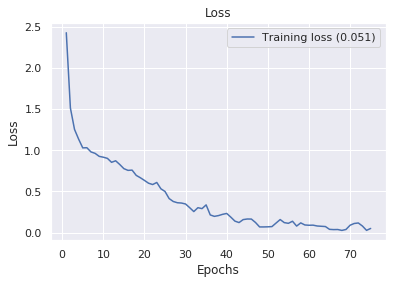

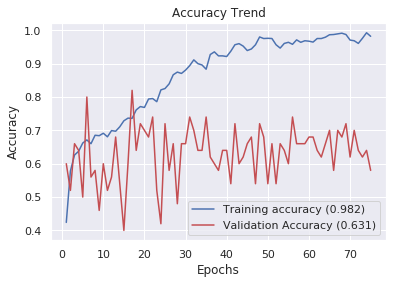

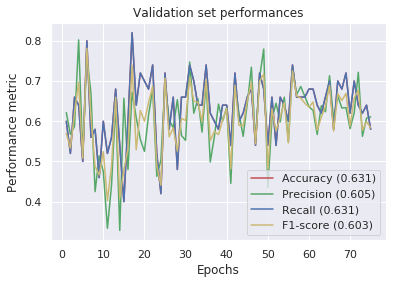

500/500 [==============================] - 4s 9ms/step
*** TEST SET PERFORMANCE EVALUATION - AlexNet CNN ***
Accuracy: 0.658
F1-score: 0.635
Recall: 0.658
Precision: 0.618

Classification Report
              precision    recall  f1-score   support

           0       0.33      0.47      0.39        15
           1       0.29      0.21      0.24        28
           2       0.20      0.16      0.18        49
           3       0.00      0.00      0.00         7
           4       0.33      0.25      0.28        56
           5       0.79      0.87      0.83       337
           6       0.00      0.00      0.00         8

    accuracy                           0.66       500
   macro avg       0.28      0.28      0.28       500
weighted avg       0.62      0.66      0.64       500



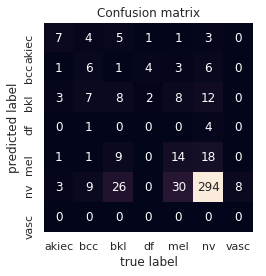

In [0]:
run_alexnet(train_df, test_df, class_labels)

### Second Pipeline:

#### Apply region-based segmentation to preprocessed images and extract the lesion region

In [0]:
segmented_region_train, segmented_region_test = images_segmentation()

Output hidden; open in https://colab.research.google.com to view.

#### Perform feature extraction (based on the ACBD method) on the segmented lesion images and build training and test sets using extracted features

In [0]:
# dictionary version:
features_train, features_test = features_extraction(segmented_region_train, segmented_region_test)

train_names = list(features_train.keys())
X_train = list(features_train.values())
y_train = [train_df[train_df['image_id'] == img_name].reset_index().at[0, 'dx'] for img_name in train_names]

test_names = list(features_test.keys())
X_test = list(features_test.values())
y_test = [test_df[test_df['image_id'] == img_name].reset_index().at[0, 'dx'] for img_name in test_names]

# DataFrame version:
# train_features_df, test_features_df = feature_extraction(segmented_region_train,
#                                                          segmented_region_test,
#                                                          out_df=True)
# X_train = [list(train_features_df.iloc[row_idx])
#            for row_idx in range(train_features_df.image_id.count())]
# y_train = train_features_df.loc[:, 'dx']
#
# X_test = [list(test_features_df.iloc[row_idx])
#           for row_idx in range(test_features_df.image_id.count())]
# y_test = test_features_df.loc[:, 'dx']

Output hidden; open in https://colab.research.google.com to view.

#### Train the SVM classifier over the training image features and use the Grid Search method in order to find the best model

The last step of the second pipeline consists in the image classification using the SVM classifier that is implemented through the `svm.SVC` class of *scikit-learn* library.  
Support vector machines are a particularly powerful and flexible class of supervised algorithms for both classification and regression.
They are an example of such a *maximum margin estimator* in fact their main goal is to construct a hyperplane (a line in a 2D space or a plane in a 3D space) in a N-dimensional space that has the largest distance to the nearest training data point of any class (also called functional margin), because in general the larger the margin, the higher the generalization power of the classifier.
The samples/points closest to the separating hyperplane are called the support vectors.  
In summary, SVM solves an optimization problem such that:
1.   Support vectors have the greatest possible distance from the functional margin (i.e., the separating hyperplane).
2.   The classes lie on different sides of the maximum-margin hyperplane.

In case of a binary linear classifier, the optimization problem is equivalent to maximizing the Geometric Margin ($\gamma$) shown in the following equation:
$$
\gamma = \min_{i \dots N} \frac{\left(\boldsymbol{w^T x_i + b}\right) y_i}{\boldsymbol{\left|\left|x\right|\right|}}
$$
where $\bf{x_i}$ is a training sample, $y_i$ is its target value (scalar) and can assume two values (1 and -1) for a binary classifier, and the separating hyperplane is parameterized by $\bf{w}$ and $\bf{b}$.

One of the most interesting features of SVMs is that if the training data are not linearly separable, instead of fitting a nonlinear function, data are firstly mapped to a new space by using a non-linear basis function (also known as *kernel*). Through the use of a kernel function (gaussian, sigmoid, radial basis function, polynomial, ...), we can convert the optimization problem to a form whose complexity depends on N, the number of training instances, and not on d because in general the new space has many more dimensions than the original space.

Moreover, in order to tune the hyperparameters of the SVC model (or put in other words, in order to find the best combination/values of the hyperparameters), we use the `GridSearchCV` class of scikit-learn library. The grid search provided by `GridSearchCV` exhaustively generates candidates from a grid of hyperparameter values specified through `param_grid` in order to optimize them through cross-validation. After finding the best values for the hyperparameters, they are used to refit the model so that it can provide the best generalization over the test data. 

For all the mathematical details and to have a complete view on SVMs see chapter 6 (Kernel Methods) of [Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/publication/pattern-recognition-machine-learning/) book written by Christopher Bishop.
In addition, please also have a look at the official documentation of scikit-learn regarding [SVM](https://scikit-learn.org/stable/modules/svm.html#svm) and [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [0]:
# clf = svm.SVC(gamma='scale', class_weight='balanced')
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

print("Training the SVM classifier...")

param_grid = {'C': [1, 1e1, 1e2, 1e3, 5e3, 1e4],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
              'class_weight': [None, 'balanced']}
clf = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, iid=False)
clf = clf.fit(X_train, y_train)

print("Best estimator found by Grid Search:")
print(clf.best_estimator_)

y_pred = clf.predict(X_test)

Training the SVM classifier...
Best estimator found by Grid Search:
SVC(C=10000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


#### Compute performance metrics (accuarcy, precision, recall and f1-score), print classification report and plot the confusion matrix

*** TEST SET PERFORMANCE EVALUATION - Segmentation + Feature Extraction + SVM ***
Accuracy: 0.684
F1-score: 0.579
Recall: 0.684
Precision: 0.556

Classification report:
              precision    recall  f1-score   support

          nv       0.00      0.00      0.00        15
       akiec       0.00      0.00      0.00        28
         bkl       0.40      0.12      0.19        49
          df       0.00      0.00      0.00         7
         mel       0.40      0.04      0.07        56
        vasc       0.70      0.99      0.82       337
         bcc       0.00      0.00      0.00         8

    accuracy                           0.68       500
   macro avg       0.21      0.16      0.15       500
weighted avg       0.56      0.68      0.58       500



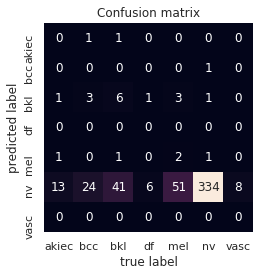

In [0]:
print('*** TEST SET PERFORMANCE EVALUATION - Segmentation + Feature Extraction + SVM ***')
# compute and plot performance metrics
accuracy = accuracy_score(y_test, y_pred)
val_f1 = f1_score(y_test, y_pred, average='weighted')
val_recall = recall_score(y_test, y_pred, average='weighted')
val_precision = precision_score(y_test, y_pred, average='weighted')

print('Accuracy: {:.3f}'.format(accuracy))
print('F1-score: {:.3f}'.format(val_f1))
print('Recall: {:.3f}'.format(val_recall))
print('Precision: {:.3f}'.format(val_precision))

print('\nClassification report:')
print(classification_report(y_test, y_pred, target_names=class_labels))

plot_confusion_matrix(y_test, y_pred, class_labels)